In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch as tc
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [70]:
X_train = pd.read_csv("Data/X_train.csv")
y_train = pd.read_csv("Data/y_train.csv")

X_test = pd.read_csv("Data/X_test.csv")
y_test = pd.read_csv("Data/y_test.csv")

In [71]:
y_train = y_train['is_fraud']

In [72]:
y_test = y_test['is_fraud']

In [73]:
X_train = X_train.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)
X_test = X_test.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1)

In [74]:
X_train.head()

,cc_num,merchant,category,amt,gender,state,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,age,trans_year,trans_month,trans_hour
0,4079773899158,208,2,-0.312202,1,13,83643,1.199391,-1.905867,-0.293736,-1.055007,1.039066,-1.972841,58,2019,4,10
1,3576281490078437,325,8,4.091703,1,15,47470,0.045491,0.262563,-0.287915,-1.015028,-0.122745,0.248130,33,2020,8,23
2,3529597810116815,227,8,-0.424044,0,38,17060,0.380290,0.896110,-0.289745,-0.813375,0.251476,0.824554,37,2019,6,8
3,213157767990030,304,11,6.785967,0,50,82901,0.604511,-1.381173,-0.201531,-0.397614,0.538835,-1.427778,39,2019,8,3
4,213180742685905,395,4,1.486784,0,4,95528,0.387990,-2.459084,-0.289899,1.116333,0.224375,-2.425539,72,2020,12,6


In [75]:
len(X_train.columns)

17

In [76]:
X_train.select_dtypes(include=['number'])

,cc_num,merchant,category,amt,gender,state,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,age,trans_year,trans_month,trans_hour
0,4079773899158,208,2,-0.312202,1,13,83643,1.199391,-1.905867,-0.293736,-1.055007,1.039066,-1.972841,58,2019,4,10
1,3576281490078437,325,8,4.091703,1,15,47470,0.045491,0.262563,-0.287915,-1.015028,-0.122745,0.248130,33,2020,8,23
2,3529597810116815,227,8,-0.424044,0,38,17060,0.380290,0.896110,-0.289745,-0.813375,0.251476,0.824554,37,2019,6,8
3,213157767990030,304,11,6.785967,0,50,82901,0.604511,-1.381173,-0.201531,-0.397614,0.538835,-1.427778,39,2019,8,3
4,213180742685905,395,4,1.486784,0,4,95528,0.387990,-2.459084,-0.289899,1.116333,0.224375,-2.425539,72,2020,12,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16979,213163860545705,513,9,-0.255315,1,10,30803,-1.063205,0.560455,-0.291709,-0.255469,-0.872660,0.596770,37,2019,8,6
16980,2229824890647120,359,4,0.311940,1,25,39572,-1.632612,0.045442,-0.289480,-1.392358,-1.456218,0.090053,65,2019,3,7
16981,30499715231997,571,11,5.613969,1,45,23117,-0.106194,0.897461,-0.263891,-0.156734,-0.141749,0.827750,85,2019,9,22
16982,503851367360,400,12,5.397766,1,27,28530,-0.625834,0.933701,-0.269282,-1.414367,-0.535132,0.920086,66,2020,7,22


In [77]:
y_train

0        1
1        1
2        0
3        1
4        1
        ..
16979    0
16980    0
16981    1
16982    1
16983    0
Name: is_fraud, Length: 16984, dtype: int64

(array([8492.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8492.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

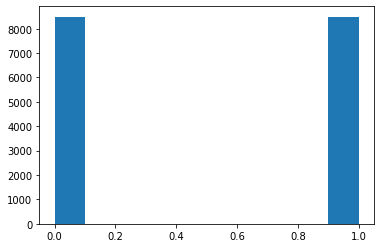

In [78]:
plt.hist(y_train)

In [79]:
class TransactionDataset(Dataset):
    def __init__(self, data, labels):
        self.data = tc.tensor(data.values, dtype=tc.float32)
        self.labels = tc.tensor(labels.values, dtype=tc.float32)
        self.length = len(data)
        
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return self.length

In [80]:
train_dataset = TransactionDataset(X_train, y_train)
test_dataset = TransactionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [81]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, in_dim=4, hide_dim=64):
        super(MLPBinaryClassifier, self).__init__()
        self._features = in_dim
        self.weights_hide = tc.nn.Parameter(tc.randn((in_dim, hide_dim)))
        self.bias_hide = tc.nn.Parameter(tc.zeros((hide_dim, ), dtype=tc.float32) + 0.1)
        self.weights_clf = tc.nn.Parameter(tc.randn((hide_dim, 1)))
        self.bias_clf = tc.nn.Parameter(tc.zeros((1, ), dtype=tc.float32) + 0.1)

    def forward(self, x):
        # Check input dimensions
        assert len(x.shape) == 2 and x.shape[1] == self._features
        
        # Linear transformation on input to produce hidden states
        hidden_states = tc.mm(x, self.weights_hide) + self.bias_hide
        
        # Apply non-linear activation (ReLU) to hidden states
        act_hidden_states = tc.relu(hidden_states)
        
        # Linear transformation on activated hidden states to produce logits
        logits = tc.mm(act_hidden_states, self.weights_clf) + self.bias_clf
        
        # Apply sigmoid activation to logits for binary classification output
        return tc.sigmoid(logits)

in_dim = X_train.shape[-1]
model = MLPBinaryClassifier(in_dim = in_dim)

model_loss = nn.BCELoss() #torch.nn.functional.nll_loss(output[idx_train], labels[idx_train])
optimizer = optim.Adam(model.parameters(), lr = 0.005)

epochs = 100
for epoch in range(epochs):
    if epoch % 5 == 0:
        print(f"Completed: {epoch}%")
    model.train()
    for batch, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = model_loss(y_pred, y_batch)
        loss.backward()
        optimizer.step()

Completed: 0%
Completed: 5%
Completed: 10%
Completed: 15%
Completed: 20%
Completed: 25%
Completed: 30%
Completed: 35%
Completed: 40%
Completed: 45%
Completed: 50%
Completed: 55%
Completed: 60%
Completed: 65%
Completed: 70%
Completed: 75%
Completed: 80%
Completed: 85%
Completed: 90%
Completed: 95%


In [82]:
model.eval()
y_pred = []
y_true = []

with tc.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred_batch = model(X_batch)
        y_pred.extend(y_pred_batch.round().detach().numpy())
        y_true.extend(y_batch.detach().numpy())
        
accuracy = accuracy_score(y_true, y_pred)
print(f"The accuracy of the model is: {round(accuracy, 4) * 100}")

The accuracy of the model is: 99.48


In [83]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classification Report:


/Users/nachikethinge/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nachikethinge/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/nachikethinge/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    221130
         1.0       0.00      0.00      0.00      1159

    accuracy                           0.99    222289
   macro avg       0.50      0.50      0.50    222289
weighted avg       0.99      0.99      0.99    222289

Confusion Matrix:
[[221130      0]
 [  1159      0]]


In [87]:
len(y_train[y_train == 1])

8492

In [88]:
len(y_train[y_train == 0])

8492

In [89]:
len(y_test[y_test == 1])

1159